<a href="https://colab.research.google.com/github/mar7i4ka/Lin_Reg/blob/main/%D0%9A%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D0%BD%D0%BE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

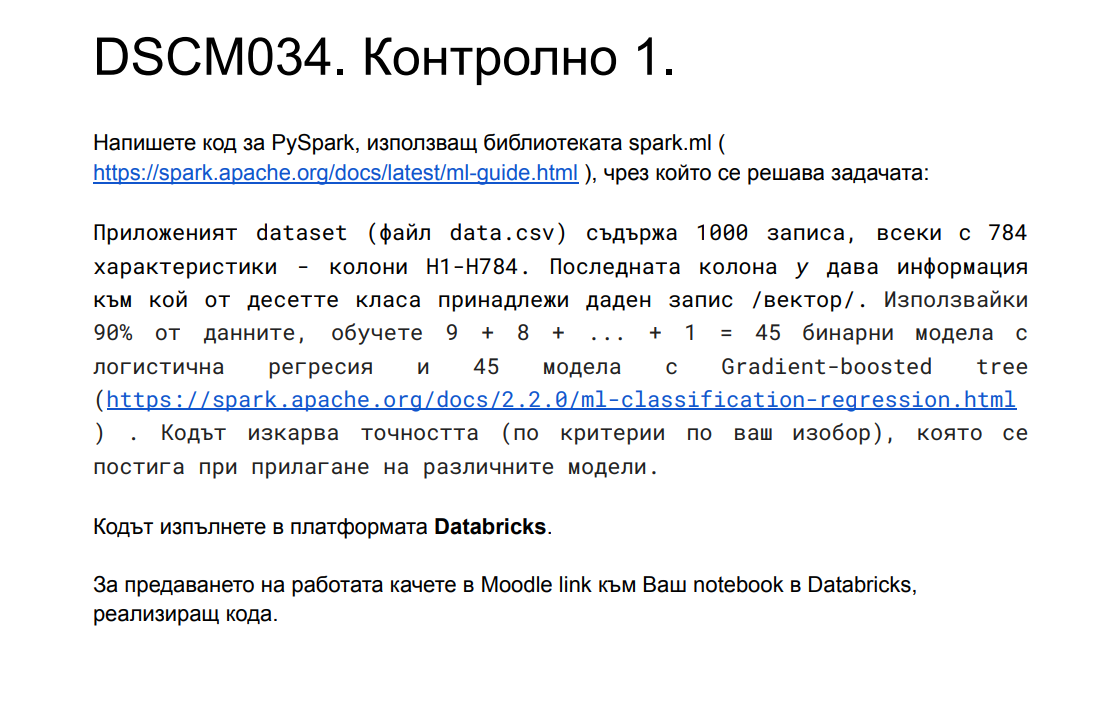

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from itertools import combinations

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv('/content/sample_data/data.csv'))

In [5]:
feature_cols = [f"H{i}" for i in range(1, 785)]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df = assembler.transform(df) \
       .select("features", col("y").alias("origLabel"))

In [6]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=42)
train_df.cache()
test_df.cache()

DataFrame[features: vector, origLabel: int]

In [11]:
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

def compute_accuracy(pred_df):
    return (pred_df
            .withColumn("correct", when(col("prediction") == col("label"), 1).otherwise(0))
            .agg(expr("avg(correct) AS accuracy"))
            .collect()[0]["accuracy"])

In [13]:
classes = [row[0] for row in df.select("origLabel").distinct().orderBy("origLabel").collect()]
pairs = list(combinations(classes, 2))

results = []
for pos_cls, neg_cls in pairs:
    train_pair = (train_df
                  .filter((col("origLabel") == pos_cls) | (col("origLabel") == neg_cls))
                  .withColumn("label", when(col("origLabel") == pos_cls, 1.0).otherwise(0.0)))
    test_pair = (test_df
                 .filter((col("origLabel") == pos_cls) | (col("origLabel") == neg_cls))
                 .withColumn("label", when(col("origLabel") == pos_cls, 1.0).otherwise(0.0)))


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
lr_model = lr.fit(train_pair)
lr_pred = lr_model.transform(test_pair)
lr_auc = evaluator_auc.evaluate(lr_pred)
lr_acc = compute_accuracy(lr_pred)





In [14]:
 # --- Gradient-Boosted Tree ---
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)
gbt_model = gbt.fit(train_pair)
gbt_pred = gbt_model.transform(test_pair)
gbt_auc = evaluator_auc.evaluate(gbt_pred)
gbt_acc = compute_accuracy(gbt_pred)
results.append((pos_cls, neg_cls, lr_auc, lr_acc, gbt_auc, gbt_acc))

In [15]:
schema = ["class_pos", "class_neg", "lr_auc", "lr_acc", "gbt_auc", "gbt_acc"]
res_df = spark.createDataFrame(results, schema)
res_df.orderBy("class_pos", "class_neg").show(45, truncate=False)

+---------+---------+-------------------+-------------------+-------+-------+
|class_pos|class_neg|lr_auc             |lr_acc             |gbt_auc|gbt_acc|
+---------+---------+-------------------+-------------------+-------+-------+
|0        |1        |0.9047619047619048 |0.9230769230769231 |1.0    |1.0    |
|0        |2        |1.0                |0.9411764705882353 |1.0    |1.0    |
|0        |3        |0.9428571428571428 |0.8235294117647058 |1.0    |1.0    |
|0        |4        |0.9591836734693877 |0.9285714285714286 |1.0    |1.0    |
|0        |5        |1.0                |1.0                |1.0    |1.0    |
|0        |6        |0.47619047619047616|0.46153846153846156|1.0    |1.0    |
|0        |7        |1.0                |1.0                |1.0    |1.0    |
|0        |8        |1.0                |1.0                |1.0    |1.0    |
|0        |9        |1.0                |1.0                |1.0    |1.0    |
|1        |2        |1.0                |0.9375             |1.0